# Problem Set #4
MACS 30150, Dr. Evans  
Minghao Yang

## 1. Some income data, lognormal distribution, and hypothesis testing (6 points)
### (a)

In [1]:
# Import the necessary libraries
import numpy as np
import scipy.stats as sts
import requests
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd

In [2]:
# Load the data as a NumPy array
incomes_1 = np.loadtxt('data/incomes.txt')

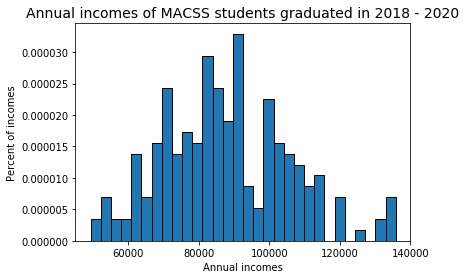

In [3]:
# Draw the histogram (normed=True is replaced by density=True to avoid warning)
num_bins = 30
ax = plt.gca()
ax.hist(incomes_1, num_bins, density=True, edgecolor='k')
ax.set_title('Annual incomes of MACSS students graduated in 2018 - 2020', fontsize=14)
ax.set_xlabel('Annual incomes')
ax.set_ylabel('Percent of incomes')
ax.set_xlim([45000, 140000])
plt.show()

### (b)

In [4]:
# Define function that generates values of a truncated lognormal pdf
def trunc_lognorm_pdf_1(xvals, mu, sigma, cut_lb='None', cut_ub='None'):
    
    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, s=sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, s=sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, s=sigma, scale=np.exp(mu)) -
                       sts.lognorm.cdf(cut_lb, s=sigma, scale=np.exp(mu)))
            
    pdf_vals = ((1 / (sigma * xvals * np.sqrt(2 * np.pi)) * 
                 np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) / prob_notcut)
    
    return pdf_vals

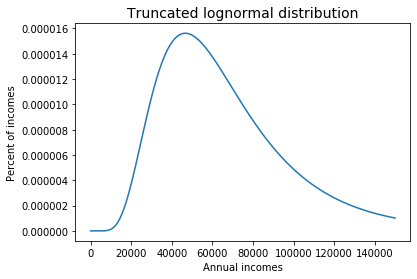

In [5]:
# Draw the lognormal distribution
pts = np.linspace(1e-10, 150000, 50000)
ax = plt.gca()
ax.plot(pts, trunc_lognorm_pdf_1(pts, 11, 0.5, cut_ub=150000))
ax.set_title('Truncated lognormal distribution', fontsize=14)
ax.set_xlabel('Annual incomes')
ax.set_ylabel('Percent of incomes')
plt.show()

In [6]:
# Define log likelihood function for the truncated lognormal distribution
def log_lik_trunc_lognorm_1(xvals, mu, sigma, cut_lb, cut_ub):
    
    pdf_vals = trunc_lognorm_pdf_1(xvals, mu, sigma, cut_lb, cut_ub)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

In [7]:
# Calculate the sum of log likelihood
print('The log likelihood is', log_lik_trunc_lognorm_1(incomes_1, 11, 0.5, 0, 150000))

The log likelihood is -2379.120591931827


### (c)

In [8]:
# Define the criterion function
def crit_1(params, *args):
    
    mu, sigma = params
    xvals, cut_lb, cut_ub = args
    log_lik_val = log_lik_trunc_lognorm_1(xvals, mu, abs(sigma), cut_lb, cut_ub)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [9]:
# minimize the negative sum of the log likelihood
mu_init_1 = 11
sig_init_1 = 1
params_init_1 = np.array([mu_init_1, sig_init_1])
MLE_args_1 = (incomes_1, 0, 150000)
results_uncstr_1 = opt.minimize(crit_1, params_init_1, args=(MLE_args_1))
mu_MLE_1, sig_MLE_1 = results_uncstr_1.x
log_lik_val_MLE_1 = -results_uncstr_1.fun
print('The MLE of mu is', mu_MLE_1)
print('The MLE of sigma is', sig_MLE_1)
print('The log likelihood given MLE is', log_lik_val_MLE_1)

The MLE of mu is 11.361699970356922
The MLE of sigma is 0.21174326319251174
The log likelihood given MLE is -2240.934337511636


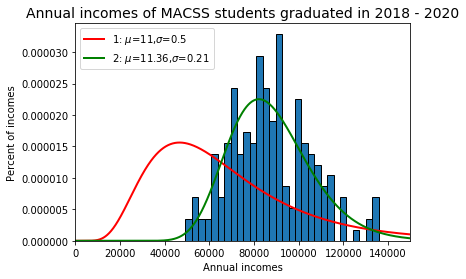

In [10]:
# Plot the histogram of the data
ax = plt.gca()
ax.hist(incomes_1, num_bins, density=True, edgecolor='k')

# Plot the two test distributions from before
ax.plot(pts, trunc_lognorm_pdf_1(pts, 11, 0.5, cut_ub=150000),
        linewidth=2, color='r', label='1: $\mu$=11,$\sigma$=0.5')

# Plot the MLE estimated distribution
ax.plot(pts, trunc_lognorm_pdf_1(pts, mu_MLE_1, sig_MLE_1, cut_ub=150000),
        linewidth=2, color='g', label='2: $\mu$=11.36,$\sigma$=0.21')

# Settings
ax.set_title('Annual incomes of MACSS students graduated in 2018 - 2020', fontsize=14)
ax.set_xlabel('Annual incomes')
ax.set_ylabel('Percent of incomes')
ax.set_xlim([0, 150000])
ax.legend(loc='upper left')
plt.show()

In [11]:
# Calculate the variance-covariance matrix
vcv_MLE_1 = results_uncstr_1.hess_inv
print('The variance-covariance matrix of the maximum likelihood estimation is\n', vcv_MLE_1)

The variance-covariance matrix of the maximum likelihood estimation is
 [[2.13592335e-04 3.04275407e-05]
 [3.04275407e-05 1.39066685e-04]]


### (d)

In [12]:
mu_test_1, sig_test_1 = np.array([11, 0.5])
log_lik_h0_1 = log_lik_trunc_lognorm_1(incomes_1, mu_test_1, sig_test_1, 0, 150000)
print('The log likelihood given hypothesis value is', log_lik_h0_1)
log_lik_MLE_1 = log_lik_trunc_lognorm_1(incomes_1, mu_MLE_1, sig_MLE_1, 0, 150000)
print('The log likelihood given MLE is', log_lik_MLE_1)
LR_val_1 = 2 * (log_lik_MLE_1 - log_lik_h0_1)
print('Likelihood ratio value is', LR_val_1)
pval_h0_1 = 1.0 - sts.chi2.cdf(LR_val_1, 2)
print('Chi squared of H0 with 2 degrees of freedom p-value is', pval_h0_1)

The log likelihood given hypothesis value is -2379.120591931827
The log likelihood given MLE is -2240.934337511636
Likelihood ratio value is 276.3725088403826
Chi squared of H0 with 2 degrees of freedom p-value is 0.0


Given that p-value is 0, we can reject $H_{0}$ at almost any level of significance. As a result, it is unlikely that the incomes are drawn from the truncated lognormal distribution with $\mu = 11$, $\sigma = 0.5$, and $0 \leq x \leq 150000$.

### (e)

In [13]:
# Probability of earning more than 100000
Prob1 = (1 - sts.lognorm.cdf(100000, s=sig_MLE_1, scale=np.exp(mu_MLE_1)) / 
         sts.lognorm.cdf(150000, s=sig_MLE_1, scale=np.exp(mu_MLE_1)))
# Probability of earning less than 75000
Prob2 = (sts.lognorm.cdf(75000, s=sig_MLE_1, scale=np.exp(mu_MLE_1)) / 
         sts.lognorm.cdf(150000, s=sig_MLE_1, scale=np.exp(mu_MLE_1)))
print('The probability of earning more than $100,000 is {:.2f}%.'.format(100 * Prob1))
print('The probability of earning less than $75,000 is {:.2f}%.'.format(100 * Prob2))

The probability of earning more than $100,000 is 23.43%.
The probability of earning less than $75,000 is 26.08%.


## 2. Linear regression and MLE (4 points)

### (a)

In [14]:
# Import data
df_2 = pd.read_csv('data/sick.txt').astype('float64')
df_2.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [15]:
# Define log likelihood function for normal distribution
def log_lik_norm_2(sick, age, children, temp_winter, beta0, beta1, beta2, beta3, sigma):
    
    epsilon = sick - beta0 - beta1 * age - beta2 * children - beta3 * temp_winter
    pdf_vals = sts.norm.pdf(epsilon, scale=sigma)
    # To avoid "divide by zero encountered in log" warning when optimizing, I replace those 0 pdfs with a small positive number
    pdf_vals[pdf_vals == 0] = 1e-10
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

In [16]:
# Define the criterion function
def crit_2(params, *args):
    
    beta0, beta1, beta2, beta3, sigma = params
    sick, age, children, temp_winter = args
    log_lik_val = log_lik_norm_2(sick, age, children, temp_winter, beta0, beta1, beta2, beta3, abs(sigma))
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [17]:
# minimize the negative sum of the log likelihood
beta0_init_2 = 0.25
beta1_init_2 = 0.01
beta2_init_2 = 0.4
beta3_init_2 = -0.01
sig_init_2 = 0.5
params_init_2 = np.array([beta0_init_2, beta1_init_2, beta2_init_2, beta3_init_2, sig_init_2])
MLE_args_2 = (df_2['sick'], df_2['age'], df_2['children'], df_2['avgtemp_winter'])
results_uncstr_2 = opt.minimize(crit_2, params_init_2, args=(MLE_args_2), method='L-BFGS-B')
beta0_MLE_2, beta1_MLE_2, beta2_MLE_2, beta3_MLE_2, sig_MLE_2 = results_uncstr_2.x
log_lik_val_MLE_2 = -results_uncstr_2.fun
vcv_MLE_2 = results_uncstr_2.hess_inv.todense()
print('The MLE of beta0 is', beta0_MLE_2)
print('The MLE of beta1 is', beta1_MLE_2)
print('The MLE of beta2 is', beta2_MLE_2)
print('The MLE of beta3 is', beta3_MLE_2)
print('The MLE of sigma is', abs(sig_MLE_2))
print('The log likelihood given MLE is', log_lik_val_MLE_2)
print('The variance-covariance matrix of the maximum likelihood estimation is\n', vcv_MLE_2)

The MLE of beta0 is 0.25164470076709944
The MLE of beta1 is 0.01293345024992607
The MLE of beta2 is 0.4005011885585702
The MLE of beta3 is -0.009991694627900977
The MLE of sigma is 0.003017697022323657
The log likelihood given MLE is 876.8650639149072
The variance-covariance matrix of the maximum likelihood estimation is
 [[ 21.27146396   8.47516915 -76.91511015  -4.32486881  -8.10346524]
 [  8.47516915   3.58433705 -32.06618346  -1.84377753  -3.17439964]
 [-76.91511015 -32.06618346 287.85679031  16.46199655  28.94919066]
 [ -4.32486881  -1.84377753  16.46199655   0.94968451   1.61335063]
 [ -8.10346524  -3.17439964  28.94919066   1.61335063   3.12843853]]


### (b)

In [18]:
beta0_test_2, beta1_test_2, beta2_test_2, beta3_test_2, sig_test_2 = np.array([1.0, 0, 0, 0, 0.1])
log_lik_h0_2 = log_lik_norm_2(df_2['sick'], df_2['age'], df_2['children'], df_2['avgtemp_winter'], 
                              beta0_test_2, beta1_test_2, beta2_test_2, beta3_test_2, sig_test_2)
print('The log likelihood given hypothesis value is', log_lik_h0_2)
log_lik_MLE_2 = log_lik_norm_2(df_2['sick'], df_2['age'], df_2['children'], df_2['avgtemp_winter'], 
                               beta0_MLE_2, beta1_MLE_2, beta2_MLE_2, beta3_MLE_2, abs(sig_MLE_2))
print('The log likelihood given MLE is', log_lik_MLE_2)
LR_val_2 = 2 * (log_lik_MLE_2 - log_lik_h0_2)
print('Likelihood ratio value is', LR_val_2)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val_2, 5)
print('Chi squared of H0 with 5 degrees of freedom p-value is', pval_h0)

The log likelihood given hypothesis value is -2253.700688042125
The log likelihood given MLE is 876.8650639149072
Likelihood ratio value is 6261.1315039140645
Chi squared of H0 with 5 degrees of freedom p-value is 0.0


Given that p-value is 0, we can reject $H_{0}$ at almost any level of significance. As a result, it is unlikely that age, number of children, and average winter temperature have no effect on the number of sick days. In other words, the likelihood is zero.